In [35]:
!pip install scapy
!pip install pyshark

# **Analyse de la Capture Wireshark : Simulation du Protocole ICMP entre l'UE et Internet**

In [45]:
# 1. Upload du fichier .pcap
from google.colab import files
uploaded = files.upload()

# 2. Lecture et analyse du fichier avec Scapy
from scapy.all import rdpcap, IP, ICMP

# Trouver le nom du fichier uploadé
pcap_file = next(iter(uploaded))

# Charger les paquets
packets = rdpcap(pcap_file)

# Initialisation
sent_times = {}
rtts = []
total_bytes = 0
first_time, last_time = None, None

# Analyse des paquets ICMP
for pkt in packets:
    if IP in pkt and ICMP in pkt and pkt[ICMP].type in [0, 8]:
        icmp_type = pkt[ICMP].type
        key = (pkt[ICMP].id, pkt[ICMP].seq)
        time = pkt.time
        size = len(pkt)

        if first_time is None:
            first_time = time
        last_time = time

        total_bytes += size

        if icmp_type == 8:
            sent_times[key] = time
        elif icmp_type == 0 and key in sent_times:
            rtt = (time - sent_times[key]) * 1000  # ms
            rtts.append(rtt)

# Calculs
avg_rtt = sum(rtts) / len(rtts) if rtts else 0
jitters = [abs(rtts[i] - rtts[i-1]) for i in range(1, len(rtts))]
avg_jitter = sum(jitters) / len(jitters) if jitters else 0
duration = last_time - first_time
bitrate = (total_bytes * 8) / duration if duration > 0 else 0
num_sent = len([pkt for pkt in packets if ICMP in pkt and pkt[ICMP].type == 8])
num_received = len(rtts)
packet_loss = ((num_sent - num_received) / num_sent) * 100 if num_sent > 0 else 0

# Résultats
print(f"Nombre de paquets envoyés: {num_sent}")
print(f"Nombre de réponses reçues: {num_received}")
print(f"RTT moyen: {avg_rtt:.2f} ms")
print(f"Jitter moyen: {avg_jitter:.2f} ms")
print(f"Débit: {bitrate/1000:.2f} kbps")
print(f"Perte de paquets: {packet_loss:.2f} %")


Saving ping_uesimtun0.pcap to ping_uesimtun0 (2).pcap
Nombre de paquets envoyés: 29
Nombre de réponses reçues: 29
RTT moyen: 84.07 ms
Jitter moyen: 45.37 ms
Débit: 1.39 kbps
Perte de paquets: 0.00 %


In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Création de l'axe temps pour les RTT
rtt_times = list(range(len(rtts)))

# Création de l'axe pour le jitter
jitter_times = list(range(len(jitters)))

# Délai entre les paquets envoyés (inter-arrival time des requêtes ICMP Echo)
echo_times = [pkt.time for pkt in packets if ICMP in pkt and pkt[ICMP].type == 8]
inter_arrival_times = [ (echo_times[i] - echo_times[i - 1]) * 1000 for i in range(1, len(echo_times))]





# RTT (Round Trip Time) — latence aller-retour

Temps entre l’envoi d’un paquet ICMP Echo Request et la réception du Echo Reply correspondant.

Donc : RTT = latence aller + latence retour


* -> Chaque point correspond à un couple (paquet envoyé, réponse reçue)

* ->  ici chaque point = une mesure de latence complète (request + reply)

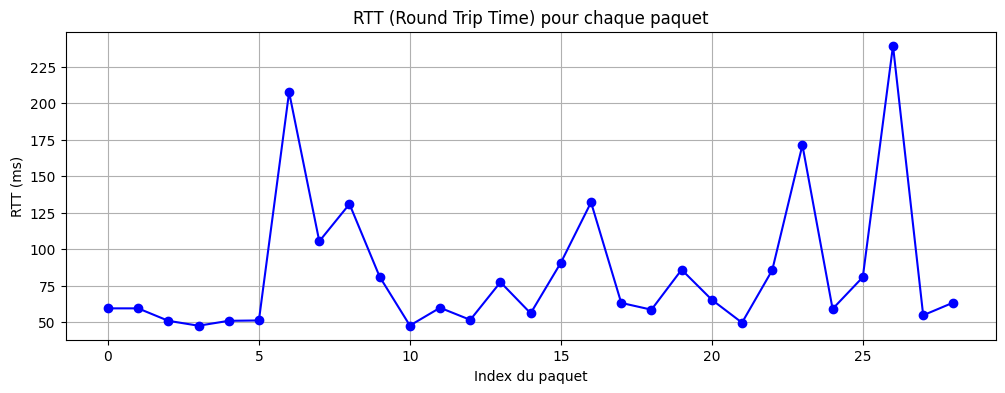

In [49]:
# 📈 RTT
plt.figure(figsize=(12, 4))
plt.plot(rtt_times, rtts, marker='o', linestyle='-', color='blue')
plt.title('RTT (Round Trip Time) pour chaque paquet')
plt.xlabel('Index du paquet')
plt.ylabel('RTT (ms)')
plt.grid(True)
plt.show()

# Variation de latence entre paquets (Jitter)

Ce graphe montre la **variation** du **RTT (latence aller-retour)** entre deux paquets consécutifs.

En d'autres termes, il mesure la différence de latence entre chaque ping et le précédent.

Le **jitter **est un indicateur important de la stabilité du réseau :

* Un jitter **faible** signifie que la **latence est constante** ➝ **bonne qualité réseau**.

* Un jitter **élevé** indique une **latence instable** ➝ **perturbations**, **congestion**, ou **instabilité**.

- Chaque point représente la **différence de RTT** entre deux pings consécutifs :
  
  `Jitter[i] = | RTT[i] - RTT[i-1] |`

- Un **jitter faible** = réseau stable, latence constante.
- Un **jitter élevé** = réseau instable, avec des pics ou creux de latence.
- Très utilisé dans l’analyse de qualité de service (QoS), surtout pour :
  - VoIP (voix sur IP)
  - Streaming
  - Jeux en ligne

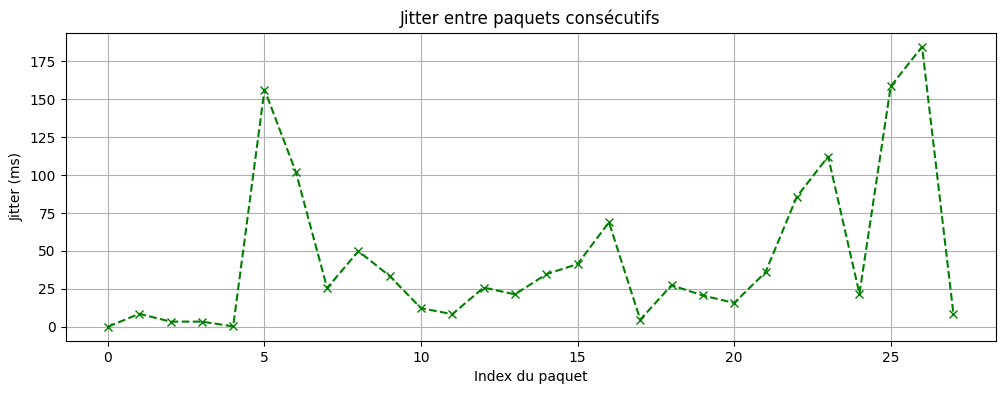

In [50]:
# 📈 Jitter
plt.figure(figsize=(12, 4))
plt.plot(jitter_times, jitters, marker='x', linestyle='--', color='green')
plt.title('Jitter entre paquets consécutifs')
plt.xlabel('Index du paquet')
plt.ylabel('Jitter (ms)')
plt.grid(True)
plt.show()

# Délais entre paquets consécutifs (Inter-Arrival Time des requêtes ICMP)

Ce graphe montre les temps entre deux envois successifs de paquets ping (ICMP Echo Request): Délais entre paquets consécutifs (Inter-Arrival Time des requêtes ICMP)

- Chaque point représente le temps écoulé (en ms) entre deux paquets ICMP Echo Request envoyés.
- C’est utile pour observer la régularité des envois `ping` :
  - Si les points sont stables : envois réguliers.
  - Si ça varie beaucoup : possible congestion, problème réseau ou irrégularité d’ordonnancement.
- Ce type de mesure est aussi appelé :
  - Inter-packet delay
  - Inter-arrival time
  - Latence entre requêtes `ping`

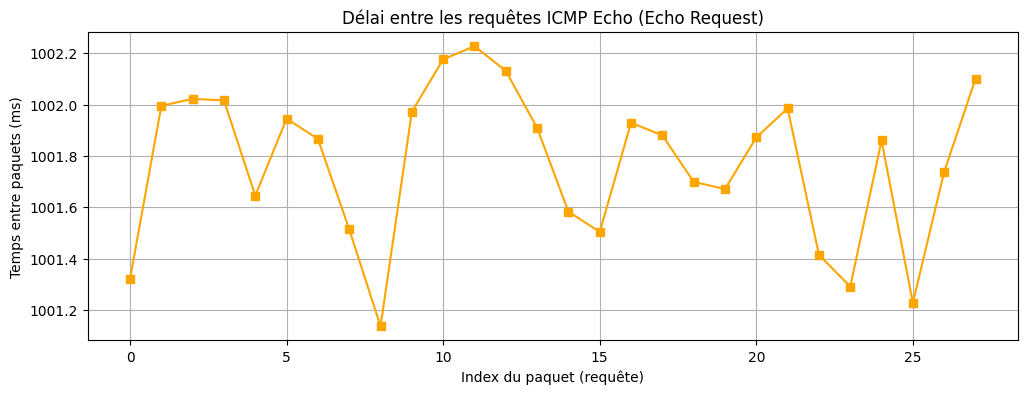

In [51]:

# 📈 Inter-Arrival Time des paquets Echo Request
plt.figure(figsize=(12, 4))
plt.plot(range(len(inter_arrival_times)), inter_arrival_times, marker='s', linestyle='-', color='orange')
plt.title("Délai entre les requêtes ICMP Echo (Echo Request)")
plt.xlabel("Index du paquet (requête)")
plt.ylabel("Temps entre paquets (ms)")
plt.grid(True)
plt.show()